In [31]:
import shutil
import os
import numpy as np
import pandas as pd
import time

from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import torch.utils.data as data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

In [2]:
def load_data_to_df(path):
    imgs = []
    paths = []
    breed  = []
    height, width = [], []

    for folder in tqdm(glob(path)):
        img = cv2.imread(folder)
        imgs.append(img)
        paths.append(folder)
        height.append(img.shape[0])
        width.append(img.shape[1])
        breed.append(folder.split("/")[3].split("-", 1)[1])
    df = pd.DataFrame({'img' : imgs, 'path': paths, 'breed': breed, 'height': height, 'width': width})
    return df

In [3]:
df = load_data_to_df("../dataset/Images/*/*")
df['breed'] = df['breed'].str.lower().str.replace("_", " ")

  0%|          | 0/20580 [00:00<?, ?it/s]

In [4]:
SEED = 42
def split_df(df, rs=SEED):
    Xy = df[["path", "breed"]]
    train, test = train_test_split(
        Xy, test_size=0.2, random_state=rs, stratify=df['breed'])
    train, valid = train_test_split(
        train, test_size=0.1, random_state=rs, stratify=train['breed'])
    return train, test, valid

In [5]:
train, test, valid = split_df(df)

In [6]:
class_map = {key:id for id, key in enumerate(df["breed"].unique())}
idx2label = {id:key for id, key in enumerate(df["breed"].unique())}
class StanfordDogDataset(Dataset):
    def __init__(self, ds, class_map=class_map, transform=None):
        self.images_filepaths = ds["path"].to_list()
        self.label = ds["breed"].to_list()
        self.label_map = class_map
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        class_id = self.label_map[self.label[idx]]
        class_id = torch.tensor(class_id)

        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, class_id

In [7]:
# Calculated means: tensor([0.4765, 0.4523, 0.3909])
# Calculated stds: tensor([0.2335, 0.2287, 0.2271])
# calc_mean_std_totensor =  A.Compose([ ToTensorV2()])
# mean_std = StanfordDogDataset(ds=train, transform=calc_mean_std_totensor)
# # mean_std = datasets.ImageFolder(root = "../42_split/train",# loader=,
# #                                 transform = transforms.ToTensor())
#
# means = torch.zeros(3)
# stds = torch.zeros(3)
#
# for img, label in tqdm(mean_std):
#     means += torch.mean(img, dim = (1,2))
#     stds += torch.std(img, dim = (1,2))
#
# means /= len(mean_std)
# stds /= len(mean_std)


means =( 0.4765, 0.4523, 0.3909)
stds = (0.2335, 0.2287, 0.2271)
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: (0.4765, 0.4523, 0.3909)
Calculated stds: (0.2335, 0.2287, 0.2271)


In [8]:
train_transform = A.Compose(

    [     A.Resize(width=32, height=32),
          # A.RandomCrop(width=30, height=30),
          A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.1),
          A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
          A.OneOf([
              A.Blur(blur_limit=3, p=0.5),
              A.ColorJitter(p=0.5),
          ], p=1.0),
          A.Normalize(
              mean=means,
              std=stds,
              max_pixel_value=255,
          ),
          ToTensorV2(),
          ]

)

test_transform = A.Compose(
    [
        A.Resize(width=32, height=32),
        # A.SmallestMaxSize(max_size=160),
        # A.CenterCrop(height=128, width=128),
        A.Normalize(mean=means, std=stds),
        ToTensorV2(),
    ]
)


In [9]:
train_dataset = StanfordDogDataset(ds=train, transform=train_transform)
val_dataset = StanfordDogDataset(ds=valid, transform=test_transform)
test_dataset = StanfordDogDataset(ds=test, transform=test_transform)

In [10]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 32,
    "num_workers": 4,
    "epochs": 10,
}

In [11]:
train_loader = data.DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)

test_loader = data.DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = data.DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [12]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object
    def __init__(self, num_classes=120):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(1600, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    # Progresses data across layers
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)

        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [13]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=120):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 9 * 9, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 128 * 9 * 9)
        x = self.classifier(x)
        return x

In [14]:
device = params["device"]
model = ConvNet().to(device)
model.to(params["device"])
criterion = nn.CrossEntropyLoss()
# also the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9)

In [15]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# FOUND_LR = 0.0001
# model = VGG(vgg11_layers).to(device)
# # optimizer = optim.Adam(model.parameters(), lr=FOUND_LR)
#
# optimizer = torch.optim.SGD(model.parameters(), lr=FOUND_LR, momentum=0.9)
#
# criterion = nn.CrossEntropyLoss()
#
# model = model.to(device)
# criterion = criterion.to(device)

In [17]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [18]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)



def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
EPOCHS = 30

best_valid_loss = float('inf')
train_data = []
for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, device)
    train_data.append([train_loss, train_acc, valid_loss, valid_acc])
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # torch.save(model.state_dict(), f'custom-vgg-model--{epoch}.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
df_res = pd.DataFrame(train_data, columns=["train_loss", "train_acc", "valid_loss", "valid_acc"])

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 3.634 | Train Acc: 15.87%
	 Val. Loss: 3.987 |  Val. Acc: 10.72%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 3.644 | Train Acc: 15.77%
	 Val. Loss: 3.996 |  Val. Acc: 10.90%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 3.637 | Train Acc: 16.17%
	 Val. Loss: 4.009 |  Val. Acc: 11.19%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 3.594 | Train Acc: 17.02%
	 Val. Loss: 4.025 |  Val. Acc: 10.31%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 3.586 | Train Acc: 16.81%
	 Val. Loss: 3.991 |  Val. Acc: 10.54%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 3.580 | Train Acc: 17.28%
	 Val. Loss: 4.004 |  Val. Acc: 11.56%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 3.564 | Train Acc: 16.99%
	 Val. Loss: 4.023 |  Val. Acc: 10.72%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 3.560 | Train Acc: 17.05%
	 Val. Loss: 3.970 |  Val. Acc: 10.96%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 3.544 | Train Acc: 17.60%
	 Val. Loss: 3.980 |  Val. Acc: 11.50%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 11s
	Train Loss: 3.514 | Train Acc: 18.24%
	 Val. Loss: 4.027 |  Val. Acc: 10.83%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 11s
	Train Loss: 3.513 | Train Acc: 18.28%
	 Val. Loss: 4.025 |  Val. Acc: 10.95%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 11s
	Train Loss: 3.490 | Train Acc: 18.37%
	 Val. Loss: 4.027 |  Val. Acc: 10.71%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 11s
	Train Loss: 3.495 | Train Acc: 18.41%
	 Val. Loss: 4.020 |  Val. Acc: 10.77%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 11s
	Train Loss: 3.483 | Train Acc: 18.02%
	 Val. Loss: 4.032 |  Val. Acc: 11.61%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 11s
	Train Loss: 3.467 | Train Acc: 19.01%
	 Val. Loss: 4.003 |  Val. Acc: 12.10%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 11s
	Train Loss: 3.446 | Train Acc: 19.33%
	 Val. Loss: 4.043 |  Val. Acc: 11.38%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 11s
	Train Loss: 3.431 | Train Acc: 19.20%
	 Val. Loss: 4.035 |  Val. Acc: 10.77%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 11s
	Train Loss: 3.428 | Train Acc: 19.33%
	 Val. Loss: 4.049 |  Val. Acc: 11.15%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 11s
	Train Loss: 3.404 | Train Acc: 20.07%
	 Val. Loss: 4.062 |  Val. Acc: 11.56%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 11s
	Train Loss: 3.385 | Train Acc: 21.06%
	 Val. Loss: 4.077 |  Val. Acc: 10.95%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 11s
	Train Loss: 3.371 | Train Acc: 21.04%
	 Val. Loss: 4.088 |  Val. Acc: 11.13%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 11s
	Train Loss: 3.352 | Train Acc: 21.19%
	 Val. Loss: 4.091 |  Val. Acc: 11.43%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 11s
	Train Loss: 3.361 | Train Acc: 21.01%
	 Val. Loss: 4.068 |  Val. Acc: 11.86%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 11s
	Train Loss: 3.337 | Train Acc: 21.27%
	 Val. Loss: 4.117 |  Val. Acc: 11.50%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 11s
	Train Loss: 3.323 | Train Acc: 21.41%
	 Val. Loss: 4.095 |  Val. Acc: 11.67%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 11s
	Train Loss: 3.299 | Train Acc: 22.12%
	 Val. Loss: 4.101 |  Val. Acc: 11.55%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0m 11s
	Train Loss: 3.310 | Train Acc: 22.18%
	 Val. Loss: 4.078 |  Val. Acc: 10.78%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 11s
	Train Loss: 3.296 | Train Acc: 22.20%
	 Val. Loss: 4.087 |  Val. Acc: 11.99%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 0m 11s
	Train Loss: 3.262 | Train Acc: 22.86%
	 Val. Loss: 4.096 |  Val. Acc: 10.97%


Training:   0%|          | 0/464 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 11s
	Train Loss: 3.282 | Train Acc: 22.93%
	 Val. Loss: 4.109 |  Val. Acc: 9.93%


In [21]:
# model.load_state_dict(torch.load('custom-vgg-model.pt'))
#
# test_loss, test_acc = evaluate(model, test_loader, criterion, device)
#
# print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [22]:
df_res

train_loss  train_acc  valid_loss  valid_acc
0     4.777024   0.012123    4.739651   0.015625
1     4.697375   0.019935    4.605957   0.027644
2     4.603944   0.024582    4.535897   0.031250
3     4.555045   0.028085    4.464953   0.037260
4     4.509578   0.031991    4.411184   0.048157
5     4.476859   0.036907    4.369915   0.045072
6     4.435418   0.041150    4.340296   0.046875
7     4.406472   0.044720    4.301294   0.055288
8     4.370959   0.048626    4.272944   0.061378
9     4.351429   0.052128    4.259117   0.055369
10    4.325472   0.052869    4.250871   0.057171
11    4.309097   0.054890    4.210058   0.060256
12    4.283339   0.057449    4.203638   0.062139
13    4.261560   0.062769    4.187471   0.064383
14    4.251828   0.063982    4.194970   0.064984
15    4.234971   0.066204    4.183073   0.068069
16    4.225175   0.064790    4.183389   0.061979
17    4.208576   0.070582    4.141693   0.071074
18    4.201207   0.074488    4.117055   0.068670
19    4.177702   0.074690    4.147770   0.062139
20    4.165929   0.077249    4.113738   0.069191
21    4.153931   0.075768    4.118439   0.070994
22    4.140331   0.078664    4.118769   0.075881
23    4.136591   0.079674    4.106624   0.080248
24    4.116962   0.080348    4.124645   0.072877
25    4.114676   0.083648    4.087245   0.075881
26    4.093334   0.087284    4.079385   0.082933
27    4.077109   0.088766    4.089615   0.080088
28    4.063841   0.088093    4.035334   0.088662
29    4.053423   0.092201    4.049877   0.086098

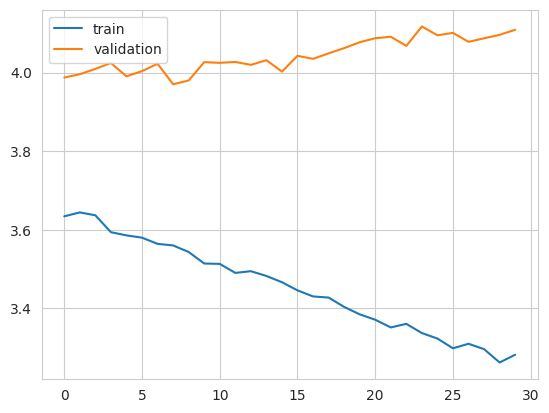

In [29]:
import matplotlib.pyplot as plt
plt.plot(df_res.train_loss, label='train')
plt.plot(df_res.valid_loss, label='validation')
plt.legend()
plt.show()

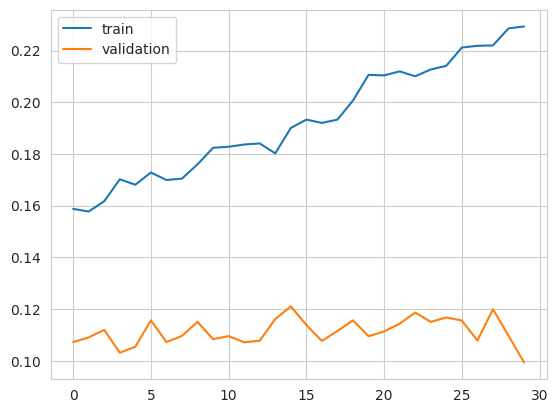

In [30]:

plt.plot(df_res.train_acc, label='train')
plt.plot(df_res.valid_acc, label='validation')
plt.legend()
plt.show()

In [34]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=40)


def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_most_incorrect(incorrect, classes, n_images, normalize=True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label.item()]
        incorrect_class = classes[incorrect_label.item()]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

In [35]:
images, labels, probs = get_predictions(model, test_loader, device)
pred_labels = torch.argmax(probs, 1)

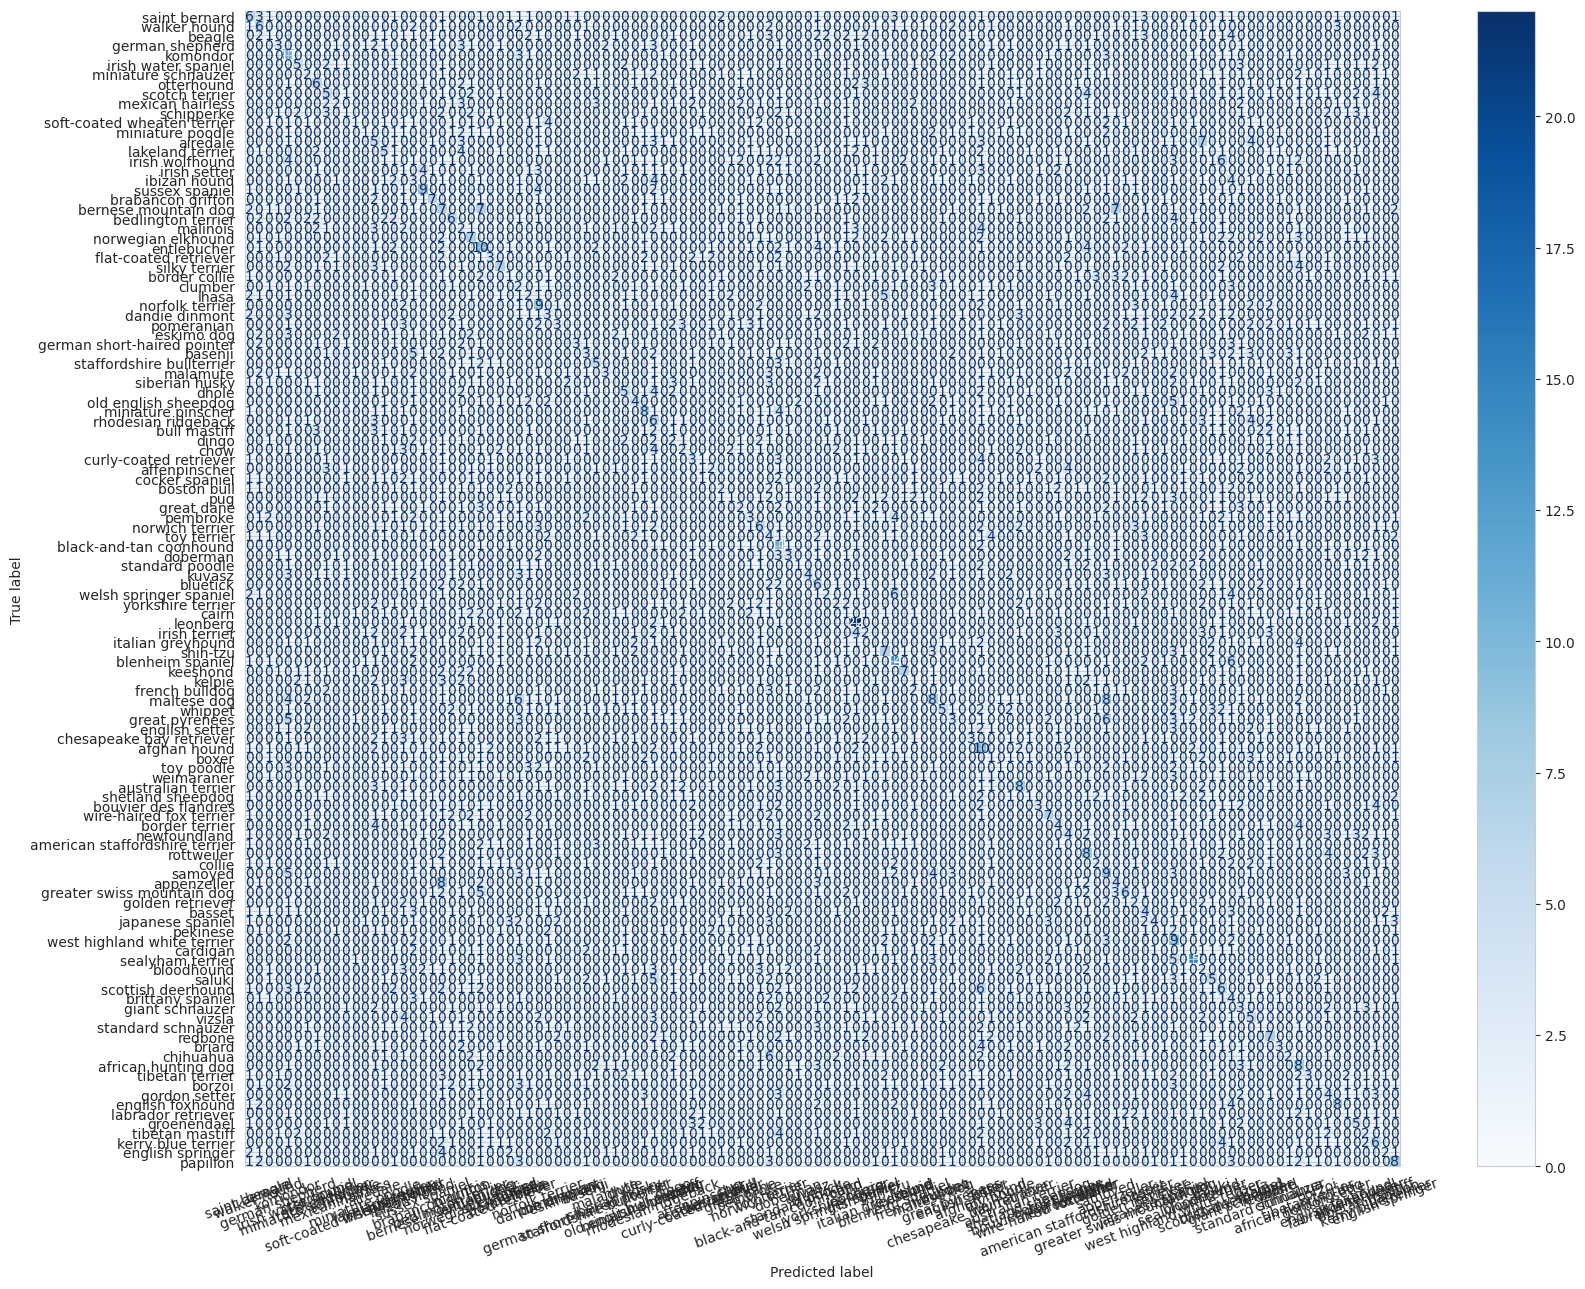

In [39]:
plot_confusion_matrix(labels, pred_labels, class_map)

In [40]:
corrects = torch.eq(labels, pred_labels)

In [41]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

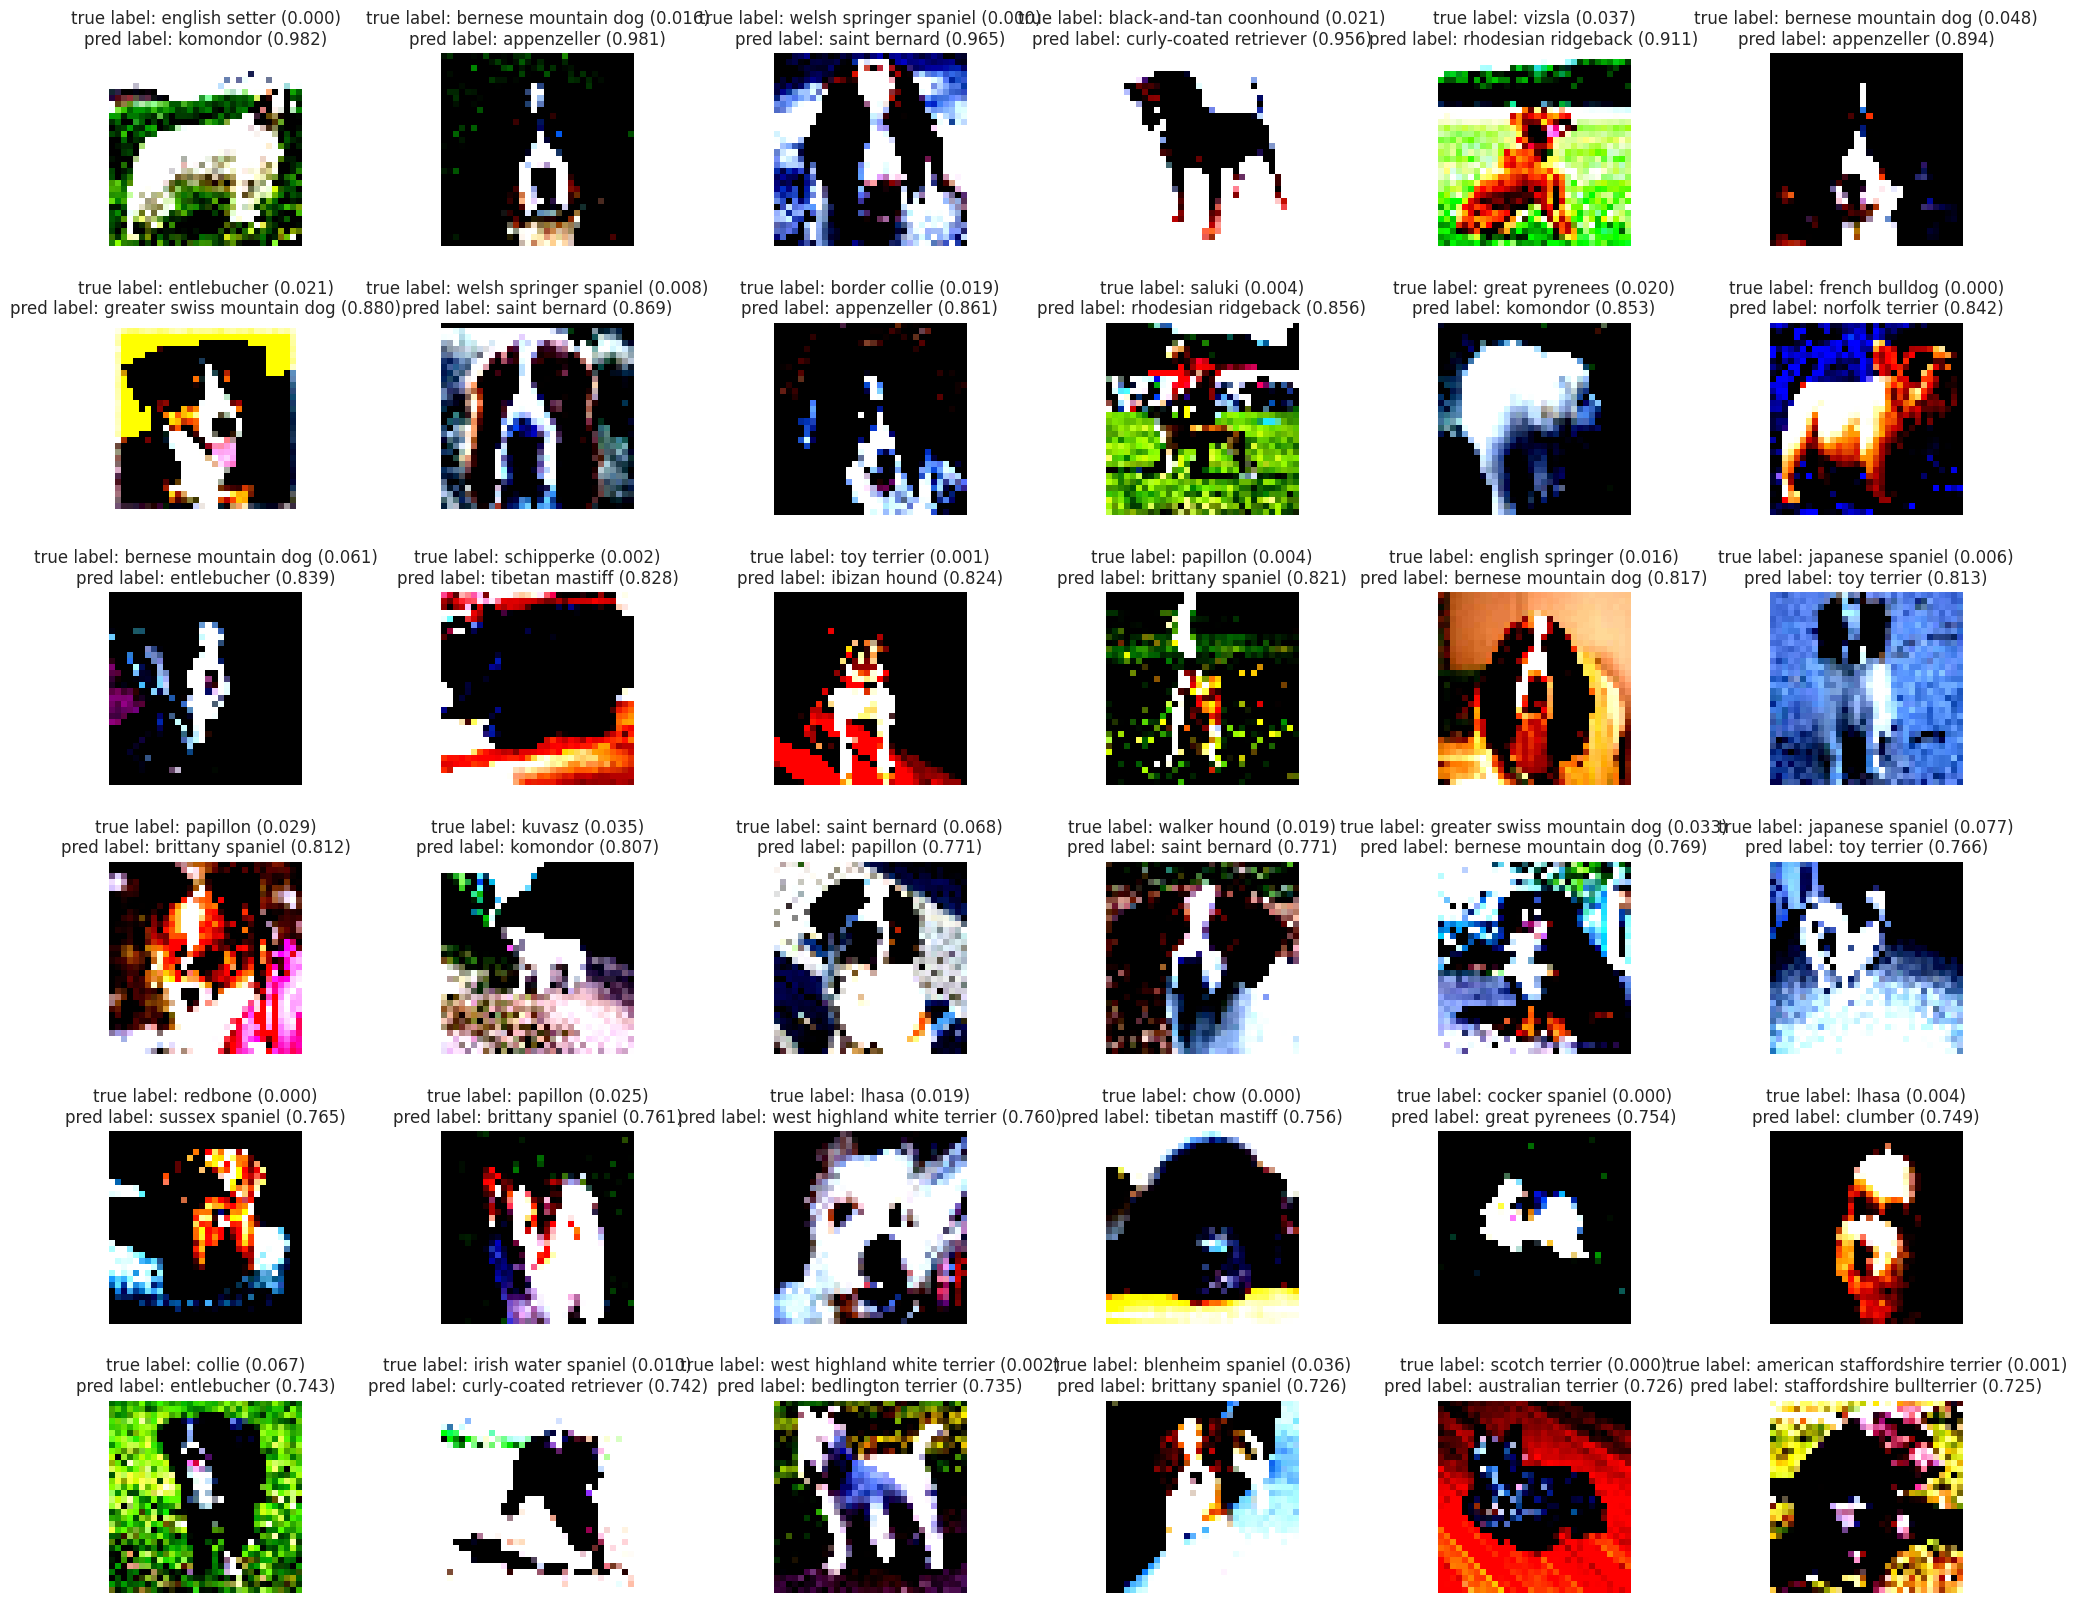

In [46]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, idx2label, N_IMAGES)